# Exploratory Data Analysis

Exploratory data analysis strongly inspired by 'https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python'. The steps to procede are:
#### Data Exploration
- Purely visual description (DONE)
- Transform images into scalar values (DONE)
- Find Correlations (TO DO)

#### Data Cleaning
- Remove/Adapt Features (TO DO)
- Test Correlations (TO DO)

## Visual Description

We first do a quick visual description of the training data set. There are two sets of 90 different images. The first set corresponds to the satellite images of what seems to be a city. These images are colored so when transforming those into scalars, there will be three different values (RGB ?). The second set correspond to the black and white version of the first set with white where there is road and black everywhere else.

The distinct elements that can be found in the pictures are houses, trees, buildings, parking lots, stadiums, train tracks, wastelands, highway and water. The detail analysis can be find in the file 'VisualExploratoryDataAnalysis.xlsx'.

The first conclusions that can be drawn from this analysis is that the pictures are taken in a dense urban area. A high percentage of the picture have houses (89%), larger buildings (36%) or even parking lots (39%). Moreover, it is clear that certain elements will make the process of detecting the road harder: trees that covers parts of or even large portion of the road are largely represented (91%), parking lots that have a road inside them, pavement is omnipresent, large portion of non-road surface (water: 4%, stadium-like structures: 9%, buildings: 36%), certain portion of wasteland (5%) that have the same colour than the roads, and last but not least the train tracks (12%) that are road-like structures that are not roads and highway portion (5%) that are road-like structures that are indeed much larger roads!

From this first quick analysis we can find three different groups:
 -The group of pictures presenting only houses and trees: Group 1 = 45%;
 -The group of pictures preventing houses, trees, larger building and parking lots: Group 2 = 14%;
 -The group of very peculiar pictures that don't correspond at all with the others: Group 0 = 8%.

## Transform images into scalar values

Before trying to approach the data analysis using correlation functions with first need to convert our image from a picture representation to a RGB-scalar representation. We do this with the help of the segment_aerial_image.ipynb notebook given with the project description.

Whether we have to use the three different values separatly or do a mean is still to be determined.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from scipy.interpolate import interp1d
import cv2

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

Loading 100 images


In [4]:
rimgs = img_float_to_uint8(imgs)
print(np.shape(rimgs))

# rimgs contains 100 picture of size 400*400 pixels in RGB values!

(100, 400, 400, 3)


## Visualizing RGB and greyscale channels

In order to understand what each channel contributes to the output, let's visualize them to see their differences

In [24]:
# let's have a look at the first image
img = rimgs[0]

img_red = img[:,:,0]
img_green = img[:,:,1]
img_blue = img[:,:,2]

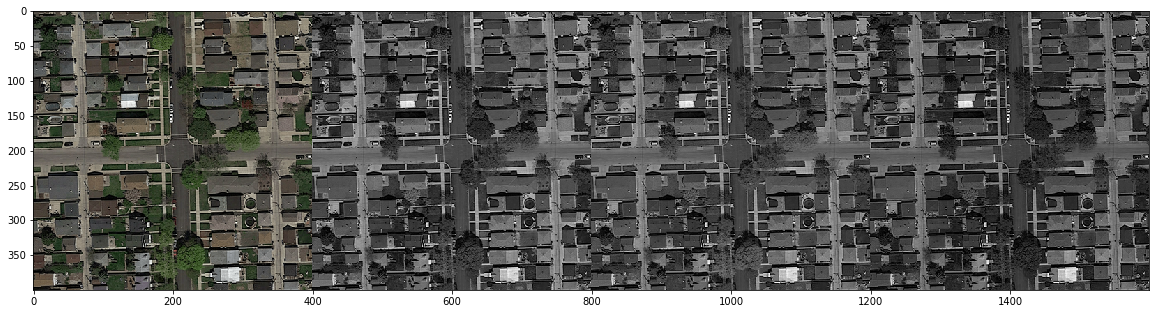

In [25]:
cimg = concatenate_images(img, img_red)
cimg = concatenate_images(cimg, img_green)
cimg = concatenate_images(cimg, img_blue)
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(cimg, cmap='Greys_r')

The images are displayed in the order: original, red channel, green channel, blue channel

It is difficult to see any difference between those channels, although one could say the trees and grass look slightly brighter in the green channel. Of course the green channel will be very important to discriminate roads from anything else, as roads are typically not green.

One thing to notice is that if we look at a greyscale image, its pixels will take only one greyscale value (say 50). But that means that its RGB value would be (50,50,50). Meaning that since our roads will typically take a shade of grey, they will contain values in the whole RGB spectrum. But as seen above, in the greyscale space, roads are even more difficult to see than in the RGB space. One processing we could do to accentuate the visibility of "not roads" would be to take the difference of the RGB channels with a greyscale image.

According to this (https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert), the following formula is used to convert from RGB to greyscale:

L = R * 299/1000 + G * 587/1000 + B * 114/1000

Let's use it to convert our original image to greyscale

In [26]:
img_grey = img_float_to_uint8(0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2])

# to compare, let's also use a mean method
img_grey_mean = img_float_to_uint8(np.sum(img, axis=2)/3)

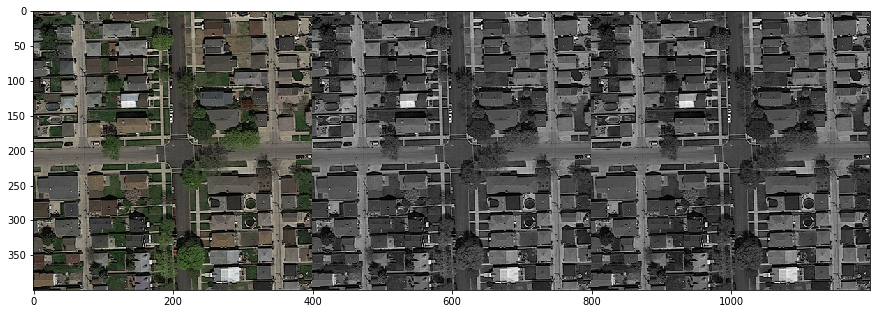

In [27]:
cimg = concatenate_images(img, img_grey)
cimg = concatenate_images(cimg, img_grey_mean)
fig1 = plt.figure(figsize=(15, 15))
plt.imshow(cimg, cmap='Greys_r')

Of course the greyscale looks a lot like each of our RGB channels as seen above, but what happens if we subtract the greyscale component from each channel? We will use a subtraction function from openCV, as it will take care of negative values

In [28]:
img_red_subtract = cv2.subtract(img_red, img_grey)
img_green_subtract = cv2.subtract(img_green, img_grey)
img_blue_subtract = cv2.subtract(img_blue, img_grey)

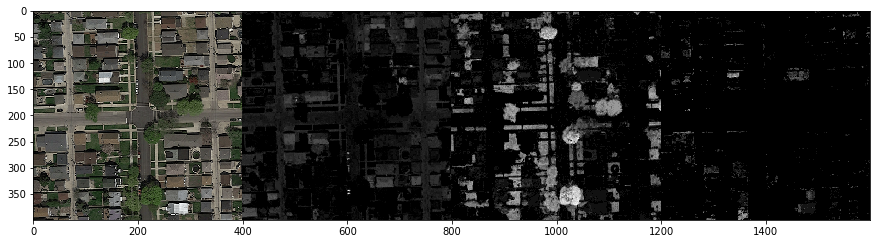

In [29]:
cimg = concatenate_images(img, img_red_subtract)
cimg = concatenate_images(cimg, img_green_subtract)
cimg = concatenate_images(cimg, img_blue_subtract)
fig1 = plt.figure(figsize=(15, 15))
plt.imshow(cimg, cmap='Greys_r')

This makes the green channel even more valuable, as the trees and grass are now very identifyable. In fact I would not be surprised if we yielded good results in a model using only this green normalized channel as input.

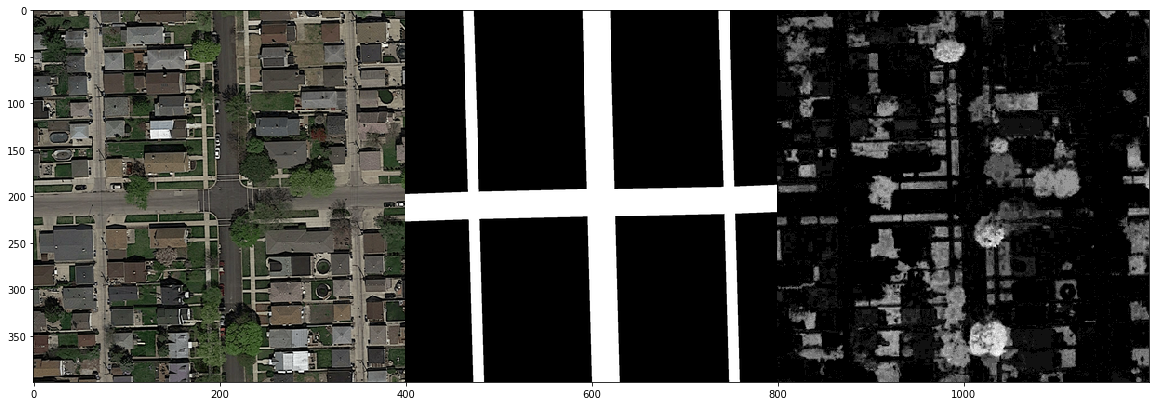

In [32]:
img_result = load_image("training/groundtruth/satImage_001.png")
cimg = concatenate_images(img, img_result)
cimg = concatenate_images(cimg, img_green_subtract)
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(cimg, cmap='Greys_r')

But this is only one image as example, it might not be as good with other images. Let's try the same thing with a more unique image

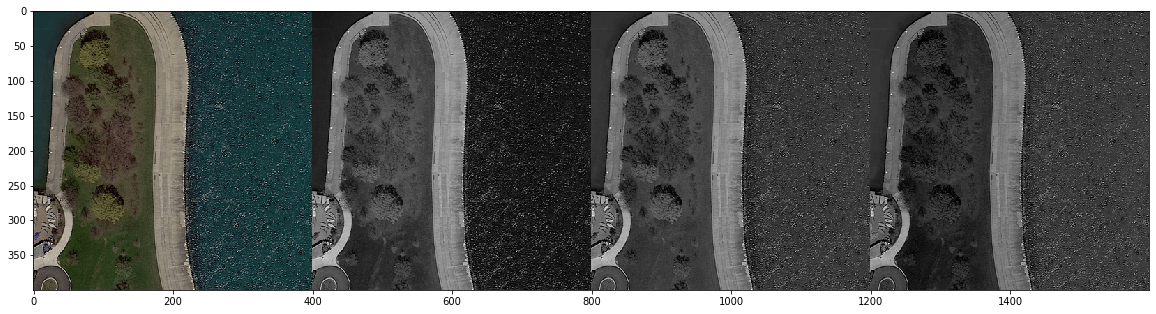

In [33]:
img = rimgs[91]

img_red = img[:,:,0]
img_green = img[:,:,1]
img_blue = img[:,:,2]

cimg = concatenate_images(img, img_red)
cimg = concatenate_images(cimg, img_green)
cimg = concatenate_images(cimg, img_blue)
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(cimg, cmap='Greys_r')

Image 92 and its RGB channels

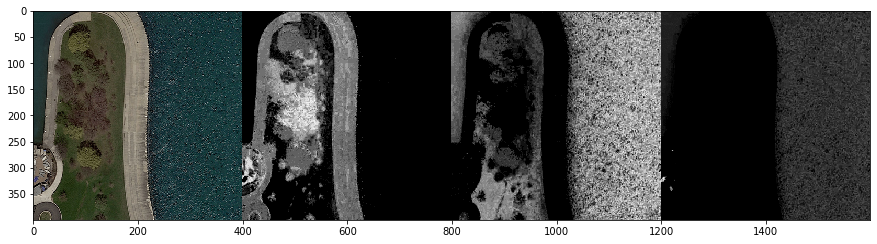

In [34]:
img_grey = img_float_to_uint8(0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2])
img_red_subtract = cv2.subtract(img_red, img_grey)
img_green_subtract = cv2.subtract(img_green, img_grey)
img_blue_subtract = cv2.subtract(img_blue, img_grey)
cimg = concatenate_images(img, img_red_subtract)
cimg = concatenate_images(cimg, img_green_subtract)
cimg = concatenate_images(cimg, img_blue_subtract)
fig1 = plt.figure(figsize=(15, 15))
plt.imshow(cimg, cmap='Greys_r')

Image 92 and its normalized RGB channels. We see that the water induces a lot of noise in the green channel. Plus in this case we could get very bad results if we based ourselves only on the normalized green channel, let's have a look:

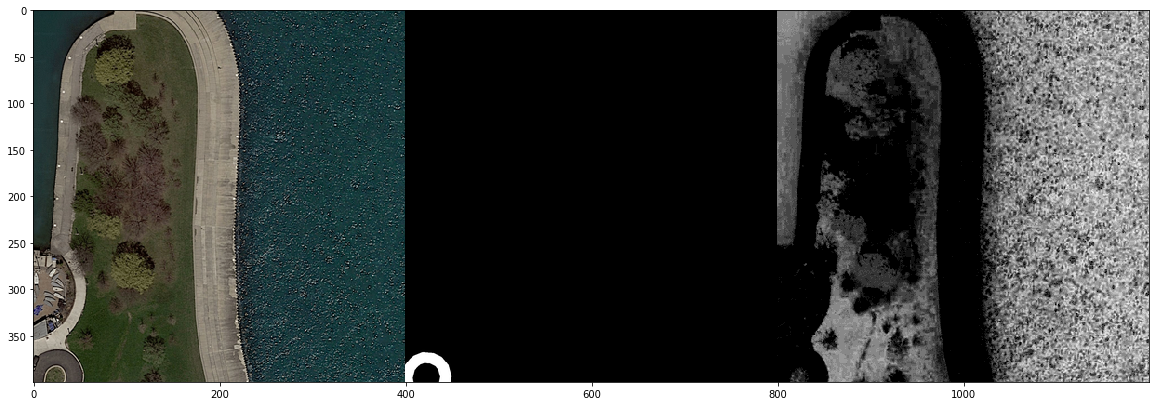

In [37]:
img_result = load_image("training/groundtruth/satImage_092.png")
cimg = concatenate_images(img, img_result)
cimg = concatenate_images(cimg, img_green_subtract)
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(cimg, cmap='Greys_r')

They have almost nothing in common. Still, this green normalized channel might be of good use as a feature later on. let's keep that in for now.

## Proposed features

Here are the functions that were provided to extract the image's features

In [39]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

Let's have a look at those features to understand them

In [42]:
# let's returm to image 1
img = rimgs[0]

feat_6d = extract_features(img)
feat_6d

array([  78.8347125 ,   78.8677875 ,   68.38210625, 1858.22314254,
       1600.25853235, 1551.17447606])

They look like the following:
- Average value of the Red channel
- Average value of the Green channel
- Average value of the Blue channel
- Variance of the Red channel
- Variance of the Green channel
- Variance of the Blue channel

__But to be honest, I have no idea what to make of this. Why would that be of any use for us? Why would they be features?
Plus, I'm not even sure we need features in a CNN, since we apply a filter to an image. The feature would be the image itself.__ anyway...

In [43]:
feat_2d = extract_features_2d(img)
feat_2d

array([  75.36153542, 1694.24178173])

Here we have:
- Mean of all RGB values of the whole picture
- Variance of all RGB values of the whole picture

__This looks even more worthless... But the interesting thing is that they recommend to use the average greyscale value. Above, we used a weighted average to calculate the greyscale. The reason this weighted average was designed in the first place is for humans, we are less sensitive to blue and more sensitive to green, so it makes sense to give a higher weight to green than to blue when averaging for humans. But in the case of a computer, a non-weighted average is just as good, so we could modify the code above to use average greyscale instead of weighted average greyscale for channel normalization.__

__After some thought, it looks like we are not asked to compute those features for the whole image, but for patches instead, where a patch is a square section of the image. In the example code, they segment the image in 16x16 patches, this reduces the whole image dimensionality from 400x400=160000 to 25x25=625 (not accounting for RGB channels, this would multiply the dimensionality by 3), so let's look at what this reduction would do__

In [61]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(1, len(files)) # Load only 1 image for this example
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Loading 1 images
satImage_001.png
Loading 1 images
satImage_001.png
Computed 625 features
Feature dimension = 2
Number of classes = 1
Class 0: 466 samples
Class 1: 159 samples


If I understand well, class 0 would correspond to patches belonging in the "background" and class 1 to the "foreground", whatever that means. Let's look at what it implies on the image

In [69]:
patch_means = X[:,0]
reduced_img = np.zeros((400,400))
class_img = np.zeros((400,400))

for i in range(400): # rows
    row_index = i//25 # will return an index between 0 and 15
    
    for j in range(400): # columns
            col_index = j//25
            
            reduced_img[i,j] = patch_means[16*row_index + col_index]
            class_img[i,j] = Y[16*row_index + col_index]
            
img_grey = img_float_to_uint8(np.sum(imgs[0], axis=2)/3) # greyscale image for comparison

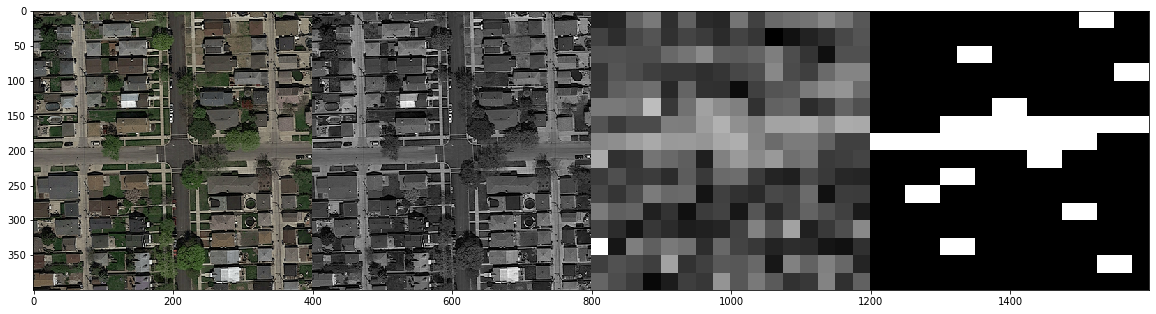

In [71]:
cimg = concatenate_images(imgs[0], img_grey)
cimg = concatenate_images(cimg, reduced_img)
cimg = concatenate_images(cimg, class_img)
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(cimg, cmap='Greys_r')

The reduced greyscale image is really bad, although we can discern the horizontal road. The class image is better for this.

These are supposed to be features, I'm not sure how it would help, although this image processing seems to be able to make out some roads in the original image. I'd gladly take someone's input on which features we should actually use and how.

An idea: convert the normalized green channel image to black and white (only 0 and 1 values), and then reduce it to patches of 16x16 the same way as the features. Then compare it to the class image above to see if we can reduce noise in the class image and add possible new roads.